# Natural Language Processing for the Fake News Challenge

## Main Imports

In [1]:
import time
import torch
import transformers
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

from joblib import dump, load
from sklearn.base import TransformerMixin
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import FeatureUnion, make_pipeline, make_union
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc, f1_score

from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import Dense

In [ ]:
!pip install transformers
import transformers

     |████████████████████████████████| 2.1MB 4.1MB/s 
     |████████████████████████████████| 3.3MB 17.4MB/s 
     |████████████████████████████████| 901kB 34.9MB/s 


## Set up the data for preprocessing
### Load and sample the data

In [2]:
data_folder_name = 'data'
train_body_filename = 'train_bodies.csv'
train_stance_filename = 'train_stances.csv'

train_body_path = data_folder_name +'/'+ train_body_filename 
train_stance_path = data_folder_name + '/' + train_stance_filename

body_data = pd.read_csv(train_body_path)
stance_data = pd.read_csv(train_stance_path)

In [3]:
body_data.sample(10)

,Body ID,articleBody
361,552,Computing giant Microsoft is one of the Silico...
229,371,Bowe Bergdahl exited Taliban captivity in exch...
420,634,A man in his mid-to-late 50s is reportedly sla...
1592,2398,"His voice served as a call to action, an echo ..."
1474,2218,"Matt Taibbi, the star magazine writer hired ea..."
1096,1649,A British-born U.S. photojournalist held by al...
1590,2391,VLADIMIR Putin’s Motorcade looks like a massiv...
1638,2463,"ABUJA, Nigeria — The leader of Nigeria's Islam..."
999,1500,Tonight — finally! — ESPN is going to have an ...
797,1196,Claim: An illustration created in response to ...


### Merge the data based on the Body ID to get one dataframe containing the corresponding Headlines and Article Bodies

In [4]:
total_data = pd.merge(body_data, stance_data, on='Body ID')

# randomly drop rows to improve performance on SVM
remove_n = 0
drop_indices = np.random.choice(total_data.index, remove_n, replace=False)
total_data = total_data.drop(drop_indices)

# add relevance column
total_data['Relevance'] = np.where(total_data['Stance'] == 'unrelated', 0, 1)
total_data.sample(10)

,Body ID,articleBody,Headline,Stance,Relevance
1549,78,"This rumour is ridiculous, but it's pretty amu...","Batmobile Stolen From ""Batman v Superman: Dawn...",disagree,1
2359,125,Islamic State militants and sympathisers are t...,Boko Haram Denies Nigeria Cease-Fire Claim,unrelated,0
37068,1974,The World Health Organisation is investigating...,New Audio Allegedly Captures Moment Michael Br...,unrelated,0
24229,1379,The video texting service Glide has verified t...,Michael Brown shooting audio caught on tape?,discuss,1
21985,1289,A new rumor making the rounds today claims tha...,"ISIS Militants In Mosul Have Contracted Ebola,...",unrelated,0
4341,244,A Catholic priest from Massachusetts had been ...,Rumor Fatigue Sets In at False Alarms of Castr...,unrelated,0
20609,1222,Not news: A fabricated story coming out of Nor...,Iraqi airstrike kills key ISIL leader,unrelated,0
2248,125,Islamic State militants and sympathisers are t...,Former Porn Star Behind YouTube Sensation ‘DC ...,unrelated,0
15576,938,A group of ISIS militants in Iraq have alleged...,ISIS militants appear to behead abducted Ameri...,unrelated,0
30238,1681,(CNN) -- Boko Haram laughed off Nigeria's anno...,Nigeria announces truce with Boko Haram; fate ...,discuss,1


### Splitting the dataset into train and validation sets

In [5]:
input_columns = total_data[['Headline', 'articleBody']]
target = 'Relevance'
X_train, X_val, y_train, y_val = train_test_split(input_columns, total_data[target].values , test_size=0.20, random_state=0)

# check the size of our datasets
print('Size of training set:', X_train.shape)
print('Size of validation set:', X_val.shape)

X_train.sample(10)

Size of training set: (39977, 2)
Size of validation set: (9995, 2)


,Headline,articleBody
24765,Low-level marijuana possession could soon land...,Police will stop arresting people for low-leve...
25241,New Audio Shows Michael Brown Was Shot at 11 T...,Apple may be planning to hold a special event ...
28928,Mum Offers to Sell Twin Boy to Save Twin Girl,THIS is the terrible moment a desperately poor...
9274,WHO investigates media reports ISIS fighters c...,A woman who claims she was Olympic swimmer Mic...
37446,State House time capsule from 1795 unearthed,"History buffs, start your engines: CNN is repo..."
307,ISIL Beheads American Photojournalist in Iraq,We’ve all seen the traditional depictions of G...
5330,Armed U.S. drones spotted flying over Syria in...,"The 45 year old Mexican/American, born in De l..."
2201,ISIS fighters 'have contracted Ebola': World H...,Claim: Deandre Joshua was murdered after testi...
27968,Fears journalist James Wright Foley beheaded b...,Michael Zehaf-Bibeau was named as the suspecte...
18697,Frisco: Sick patient claims to have had contac...,Spotting a spider on the floor may give you a ...


## TF-IDF Feature Extraction
### Custom Transformer for Pipeline

In [ ]:
# custom transformer for column extraction
class ColumnExtractor(TransformerMixin):

    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]

### Pipelines and Feature Union of Headline and Article Body
- Apply fit transform

In [ ]:
# feature extraction with TF-IDF

# create pipes and perform TF-IDF on Headline and Body columns
headline_pipe = make_pipeline(
    ColumnExtractor('Headline'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=200, lowercase=True)
)

body_pipe = make_pipeline(
    ColumnExtractor('articleBody'),
    TfidfVectorizer(decode_error='ignore', min_df=4, max_df=0.5, max_features=200, lowercase=True)
)

# combine headline and body transformers with a feature union and weight equally
preprocessor = FeatureUnion(transformer_list=[('headline', headline_pipe),
                                              ('body', body_pipe)],
                            transformer_weights= {
                                    'headline': 0.5,
                                    'body': 0.5
                               }
                           )

# fit transform and print data
train = preprocessor.fit_transform(X_train).todense()
val = preprocessor.transform(X_val).todense()
print('Train size: ', train.shape)
print('Val size: ', val.shape)

Train size:  (39977, 400)
Val size:  (9995, 400)


## Evaluation Metrics

### Confusion Matrix

In [6]:
# Create the confusion matrix
def plot_confusion_matrix(y_test, y_pred):
    ''' Plot the confusion matrix for the target labels and predictions '''
    cm = confusion_matrix(y_test, y_pred)

    # Create a dataframe with the confusion matrix values
    df_cm = pd.DataFrame(cm, range(cm.shape[0]),
                  range(cm.shape[1]))

    # Plot the confusion matrix
    sn.set(font_scale=1.4) #for label size
    sn.heatmap(df_cm, annot=True,fmt='.0f',cmap="YlGnBu",annot_kws={"size": 10})# font size
    plt.show()

### ROC Curve

In [7]:
# ROC Curve
# plot no skill
# Calculate the points in the ROC curve
def plot_roc_curve(y_test, y_pred):
    ''' Plot the ROC curve for the target labels and predictions'''
    fpr, tpr, thresholds = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc= auc(fpr,tpr)
    plt.figure(figsize=(12, 12))
    ax = plt.subplot(121)
    ax.set_aspect(1)
    
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

### Display the Confusion Matrix and ROC Curve results

In [8]:
def display_results(model, val, y_val):

    y_pred = model.predict(val)

    print(metrics.classification_report(y_val, y_pred))
    plot_confusion_matrix(y_val, y_pred)

    # convert to 0s and 1s for plotting ROC curve
    roc_y_val = [np.int64(1) if i == 'related' else np.int64(0) for i in y_val]
    roc_y_pred = [np.int64(1) if i == 'related' else np.int64(0) for i in y_pred]

    plot_roc_curve(roc_y_val, roc_y_pred)

## Machine Learning Models

### Support Vector Machine Classifier

In [9]:
def train_SVM(train, y_train, extractor):

    start = time.time()
    parameters = {
        'C': [1, 10],
        'gamma': [1, 'auto', 'scale']
    }
    # Tune hyperparameters  using Grid Search and a SVM model
    model = GridSearchCV(SVC(kernel='rbf'), parameters, cv=5, n_jobs=-1).fit(train, y_train)
    dump(model, extractor + '_SVM.joblib')

    end = time.time()
    print("Training took", end - start, "seconds")

    return model

### Train SVM using TF-IDF Features and display results

In [ ]:
model = train_SVM(train, y_train, "tfidf")

Training took 6708.22327542305 seconds


              precision    recall  f1-score   support

     related       0.90      0.87      0.89      2767
   unrelated       0.95      0.96      0.96      7228

    accuracy                           0.94      9995
   macro avg       0.93      0.92      0.92      9995
weighted avg       0.94      0.94      0.94      9995



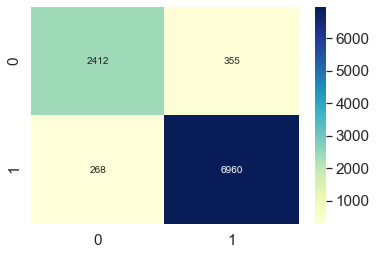

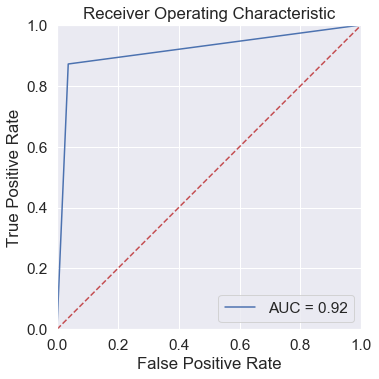

In [ ]:
display_results(model, val, y_val)

# Tokenisation with BERT

### Load the model and tokeniser

In [10]:
model_class, tokenizer_class, pretrained_weights = (transformers.DistilBertModel,
                                                    transformers.DistilBertTokenizer,
                                                    'distilbert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)
model = model_class.from_pretrained(pretrained_weights)

### Embedding Retrieval

In [11]:
def get_embeddings(data, batch_size):

    # set device and lambda function for classification token retrieval
    device = torch.device("cuda")
    get_cls = lambda x: x[0][:, 0, :].squeeze()
    bert_embeddings = []  # initialise embeddings

    for i in range(batch_size, data.shape[0] + batch_size, batch_size):
    
        if i % 100 == 0:
            print("Batch", i)
        
        # tokenise
        tokenized = tokenizer(list(data['Headline'][i - batch_size:i]), list(data['articleBody'][i - batch_size:i]),\
                          padding='max_length', truncation=True, return_tensors="pt")
        
        # get input ids and set to device
        tokenized_text = tokenized['input_ids']
        tokenized_text = tokenized_text.to(device)

        # calculate embeddings and retrieve cls token embedding
        with torch.no_grad():
            embeddings = model(tokenized_text)
        cls_embeddings = get_cls(embeddings)

        # append to total embeddings
        if bert_embeddings == []:
            bert_embeddings = cls_embeddings
        else:
            bert_embeddings = torch.cat((bert_embeddings, cls_embeddings), 0)

        # clear cache and GPU memory
        del embeddings
        torch.cuda.empty_cache()

    return bert_embeddings

In [12]:
from google.colab import drive
drive.mount('/content/drive')

device = torch.device("cuda")
model = model.to(device)
batch_size = 128

print("Training Set")
train = get_embeddings(X_train, batch_size)

print("Testing Set")
val = get_embeddings(X_val, batch_size)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Training Set
Batch 3200
Batch 6400
Batch 9600
Batch 12800
Batch 16000
Batch 19200
Batch 22400
Batch 25600
Batch 28800
Batch 32000
Batch 35200
Batch 38400
Testing Set
Batch 3200
Batch 6400
Batch 9600


### Train SVM using BERT Embeddings and display results

In [ ]:
model = train_SVM(train.cpu(), y_train, 'bert')

              precision    recall  f1-score   support

     related       0.57      0.06      0.11        64
   unrelated       0.75      0.98      0.85       186

    accuracy                           0.75       250
   macro avg       0.66      0.52      0.48       250
weighted avg       0.71      0.75      0.66       250



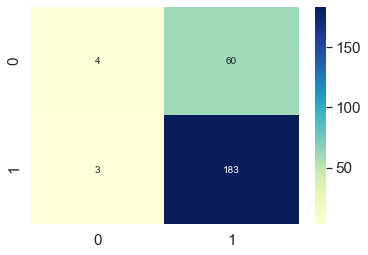

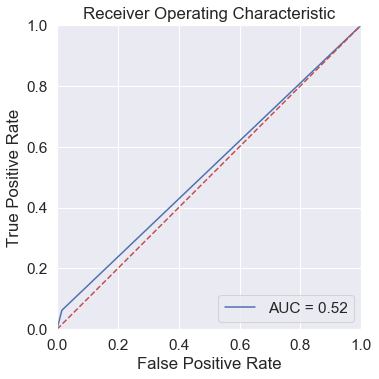

In [ ]:
display_results(model, val[:250], y_val[:250])

## Deep Learning Models

### Long Short-Term Memory (LSTM)

In [ ]:
embed_dim = 200
lstm_out = 200
batch_size = 32

model = Sequential()
model.add(LSTM(units=400, input_shape=train.shape, return_sequences=True))
#model.add(Embedding(train.shape[0], embed_dim, input_length = train.shape[1]))
model.add(LSTM(units=6, return_sequences=True))
#model.add(LSTM(lstm_out))
model.add(Dense(1, activation='softmax', name='output'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['categorical_accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 39977, 400)        1281600   
_________________________________________________________________
lstm_1 (LSTM)                (None, 39977, 6)          9768      
_________________________________________________________________
output (Dense)               (None, 39977, 1)          7         
Total params: 1,291,375
Trainable params: 1,291,375
Non-trainable params: 0
_________________________________________________________________
None


### Training

In [ ]:
model.fit(train, y_train, batch_size=batch_size, epochs=2, verbose=5)

Epoch 1/2


ValueError: ignored

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7228
           1       0.28      1.00      0.43      2767

    accuracy                           0.28      9995
   macro avg       0.14      0.50      0.22      9995
weighted avg       0.08      0.28      0.12      9995



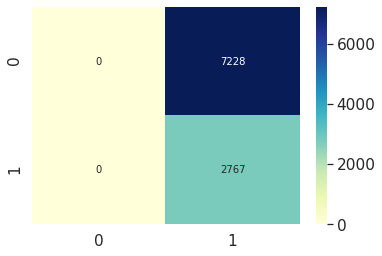

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_ranking.py:808: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  UndefinedMetricWarning)


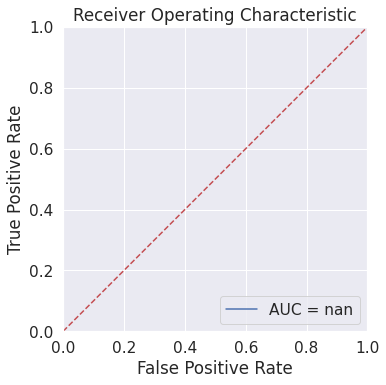

In [ ]:
display_results(model, val, y_val)

### Initialise and train